In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
DATA_DIR = Path().cwd() / 'data'

In [3]:
assert DATA_DIR.exists()

# Read in .TRM files

In [4]:
dfs = [pd.read_csv(filename) for filename in DATA_DIR.glob('*.TRM')]

In [5]:
df = dfs[0]

In [6]:
df.head()

,File: Users\stell\Desktop\StellarDat\South 1 -\r\n TRANS-> Wave:2830.74nm Pix:1050 Val:-2441.190 Time: 45ms Avg:10 Sm:2 Sg:0 Tc:off SNAP Xt:3 Ch:1 Xtrig
0,862.13 1.0000E-003
1,863.88 1.0000E-003
2,865.63 1.0000E-003
3,867.38 -2.0552E+002
4,869.13 -7.8509E+002


## extract the header information

In [7]:
info = df.columns[0]

## extract the time series info

In [8]:
data = df.iloc[:,0]

In [9]:
data

0        862.13  1.0000E-003
1        863.88  1.0000E-003
2        865.63  1.0000E-003
3       867.38  -2.0552E+002
4       869.13  -7.8509E+002
               ...          
505     1745.88  4.0873E+001
506     1747.63  4.0831E+001
507     1749.38  4.0831E+001
508     1751.13  4.0827E+001
509     1752.88  4.0896E+001
Name:  File: Users\stell\Desktop\StellarDat\South 1 -\r\n  TRANS->  Wave:2830.74nm  Pix:1050  Val:-2441.190  Time: 45ms  Avg:10  Sm:2  Sg:0  Tc:off  SNAP  Xt:3  Ch:1  Xtrig  , Length: 510, dtype: object

## get number of steps in time series

In [10]:
len(data)

510

## remove whitespace

In [11]:
data = data.str.strip()

## split columns on space

In [12]:
data = data.str.partition(' ')

In [13]:
data.head()

,0,1,2
0,862.13,,1.0000E-003
1,863.88,,1.0000E-003
2,865.63,,1.0000E-003
3,867.38,,-2.0552E+002
4,869.13,,-7.8509E+002


## get first column as wavelengths

In [14]:
wavelengths = data[0]
wavelengths.head()

0    862.13
1    863.88
2    865.63
3    867.38
4    869.13
Name: 0, dtype: object

## convert wavelengths to float (decimal numbers)

In [15]:
wavelengths = wavelengths.astype(float)
wavelengths.head()

0    862.13
1    863.88
2    865.63
3    867.38
4    869.13
Name: 0, dtype: float64

In [16]:
wavelengths.describe()

count     510.000000
mean     1307.505000
std       257.895025
min       862.130000
25%      1084.817500
50%      1307.505000
75%      1530.192500
max      1752.880000
Name: 0, dtype: float64

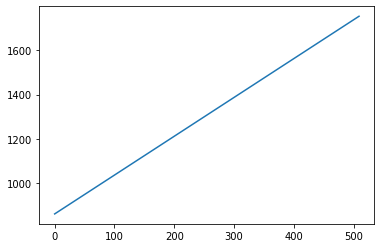

In [17]:
plt.plot(wavelengths)

## extract transmittance

In [18]:
transmittance = data[2]
transmittance.head()

0      1.0000E-003
1      1.0000E-003
2      1.0000E-003
3     -2.0552E+002
4     -7.8509E+002
Name: 2, dtype: object

## convert transmittance to float

In [19]:
transmittance = transmittance.astype(float)

In [20]:
transmittance.head()

0      0.001
1      0.001
2      0.001
3   -205.520
4   -785.090
Name: 2, dtype: float64

In [21]:
transmittance.describe()

count    510.000000
mean      44.613453
std       44.085151
min     -785.090000
25%       41.873250
50%       49.401500
75%       54.408250
max       55.586000
Name: 2, dtype: float64

## remove transmittance values that are less than 0 and corresponding wavelengths

In [22]:
mask = transmittance > 0
transmittance = transmittance[mask]
wavelengths = wavelengths[mask]

In [23]:
# plot transmittance vs wavelength

In [24]:
def plot_sample(wavelengths, transmittance):
    plt.figure(figsize=(20,10))
    plt.title('Transmittance vs Wavelength')
    plt.xlabel('Wavelength(nm)')
    plt.ylabel('Transmittance (counts)')
    plt.plot(wavelengths, transmittance)

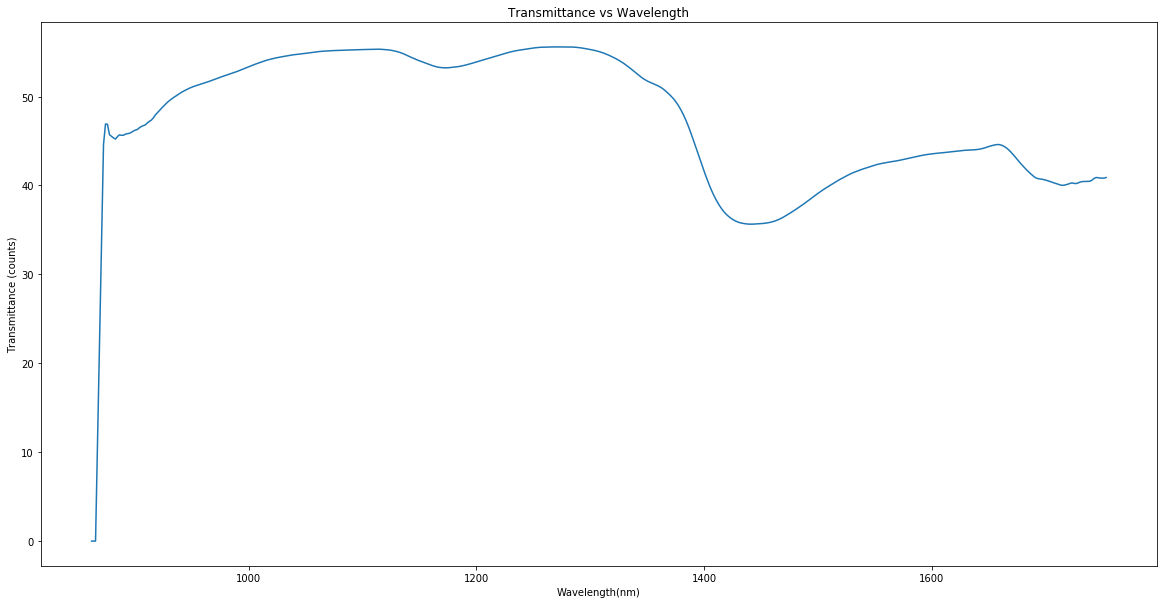

In [25]:
plot_sample(wavelengths, transmittance)

# convert TRM to sample

In [26]:
transmittance

0       0.001
1       0.001
2       0.001
6      44.607
7      46.916
        ...  
505    40.873
506    40.831
507    40.831
508    40.827
509    40.896
Name: 2, Length: 507, dtype: float64

In [27]:
pd.DataFrame([transmittance.values], columns=wavelengths)

,862.13,863.88,865.63,872.63,874.38,876.13,877.88,879.63,881.38,883.13,...,1737.13,1738.88,1740.63,1742.38,1744.13,1745.88,1747.63,1749.38,1751.13,1752.88
0,0.001,0.001,0.001,44.607,46.916,46.875,45.709,45.524,45.351,45.222,...,40.46,40.49,40.609,40.794,40.896,40.873,40.831,40.831,40.827,40.896


In [28]:
def _extract_trm_filename_info(filename):
    sample_name_method, _, _ = filename.partition('-')
    if '(' in sample_name_method:
        sample_name, _, process_method = sample_name_method.partition('(')
        sample_name = sample_name.strip()
        process_method = process_method.strip()[:-1] # drop )
    else:
        sample_name = sample_name_method.strip()
        process_method = ''
    sample_date = pd.to_datetime(filename.partition('-')[2].partition('#')[0])
    run_number = filename.partition('#')[2].partition('.')[0]
    return sample_name, process_method, sample_date, run_number

In [29]:
def parse_trm(trm_path, drop_neg_trans=False):
    trm_path = Path(trm_path)
    df = pd.read_csv(trm_path)
    extra_info = df.columns[0]
    data = df.iloc[:,0]\
             .str.strip()\
             .str.partition(' ')
    wavelengths = data[0].astype(float)
    transmittance = data[2].astype(float)
    if drop_neg_trans:
        mask = transmittance > 0
        transmittance = transmittance[mask]
        wavelengths = wavelengths[mask]
    sample_df = pd.DataFrame([transmittance.values], columns=wavelengths)
    sample_df['extra_info'] = extra_info
    sample_df['filename'] = trm_path.name
    sample_name, process_method, sample_date, run_number = _extract_trm_filename_info(trm_path.name)
    sample_df['sample_name'] = sample_name
    sample_df['sample_date'] = sample_date
    sample_df['run_number'] = run_number
    sample_df['process_method'] = process_method
    return sample_df

In [30]:
def parse_trms(trm_directory):
    trm_directory = Path(trm_directory)
    return pd.concat([parse_trm(trm_filepath) for trm_filepath in trm_directory.glob("*.TRM")])

In [31]:
df_trms = parse_trms(DATA_DIR)

/Users/gabriel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
df_trms

,862.13,863.88,865.63,872.63,874.38,876.13,877.88,879.63,881.38,883.13,...,1752.88,extra_info,filename,sample_name,sample_date,run_number,process_method,867.38,869.13,870.88
0,0.001,0.001,0.001,44.607,46.916,46.875,45.709,45.524,45.351,45.222,...,40.896,File: Users\stell\Desktop\StellarDat\South 1 ...,South 1 - 7-8-20-20 #3.TRM,South 1,2020-07-08 20:00:00,3,,NaN,NaN,NaN
0,0.001,0.001,0.001,62.212,63.387,62.820,61.350,61.013,61.046,61.092,...,57.145,File: Users\stell\Desktop\StellarDat\South 15...,South 15 - 7-8-20-20 #1.TRM,South 15,2020-07-08 20:00:00,1,,87.1960,378.9500,286.15000
0,0.001,0.001,0.001,44.734,47.000,46.914,45.672,45.429,45.315,45.234,...,41.020,File: Users\stell\Desktop\StellarDat\South 1 ...,South 1 - 7-8-20-20 #2.TRM,South 1,2020-07-08 20:00:00,2,,NaN,NaN,NaN
0,0.001,0.001,0.001,62.392,63.609,63.036,61.592,61.262,61.365,61.483,...,57.487,File: Users\stell\Desktop\StellarDat\South 15...,South 15 - 7-8-20-20 #3.TRM,South 15,2020-07-08 20:00:00,3,,90.0710,391.9300,295.60000
0,0.001,0.001,0.001,62.540,63.678,63.054,61.546,61.143,61.226,61.317,...,57.309,File: Users\stell\Desktop\StellarDat\South 15...,South 15 - 7-8-20-20 #2.TRM,South 15,2020-07-08 20:00:00,2,,99.6530,429.7000,317.57000
0,0.001,0.001,0.001,44.739,46.914,46.817,45.606,45.404,45.296,45.215,...,40.808,File: Users\stell\Desktop\StellarDat\South 1 ...,South 1 - 7-8-20-20 #1.TRM,South 1,2020-07-08 20:00:00,1,,NaN,NaN,NaN
0,0.001,0.001,0.001,67.104,69.003,68.605,67.014,66.624,66.569,66.552,...,61.972,File: Users\stell\Desktop\StellarDat\South 16...,South 16 - 7-8-20-20 #2.TRM,South 16,2020-07-08 20:00:00,2,,16.9290,46.9600,33.31900
0,0.001,0.001,0.001,57.515,60.162,60.005,58.601,58.336,58.178,58.064,...,51.934,File: Users\stell\Desktop\StellarDat\South 2 ...,South 2 - 7-8-20-20 #1.TRM,South 2,2020-07-08 20:00:00,1,,NaN,NaN,NaN
0,0.001,0.001,0.001,56.305,58.094,57.690,56.142,55.770,55.735,55.770,...,51.705,File: Users\stell\Desktop\StellarDat\South 17...,South 17 (Ground) - 7-8-20-20 #2.TRM,South 17,2020-07-08 20:00:00,2,Ground,NaN,NaN,NaN
0,0.001,0.001,0.001,35.573,36.845,36.378,34.870,34.521,34.453,34.447,...,31.318,File: Users\stell\Desktop\StellarDat\Raw - Co...,Hampton Coulter - 6-15-20 #3.TRM,Hampton Coulter,2020-06-15 00:00:00,3,,6.6416,31.0670,38.88900


# check for null values

In [33]:
df_trms[df_trms.isnull()]

,862.13,863.88,865.63,872.63,874.38,876.13,877.88,879.63,881.38,883.13,...,1752.88,extra_info,filename,sample_name,sample_date,run_number,process_method,867.38,869.13,870.88
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
